# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 1
#! source activate tensorflow

# 1) Libraries

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 20, 6 )

# 2) Import

In [4]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

path_data = os.path.join(ROOTPATH, 'Data')
path_train = os.path.join(path_data, 'train_set')
path_test = os.path.join(path_data, 'test_set')
path_validation = os.path.join(path_data, 'validation_set')

## Import the list of tickers

In [5]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

## Importing functions

In [6]:
def get_data(path):
    list_dataframes=[]
    allFiles = glob.glob(path + "/csv" + "*.csv")
    i = 0
    list_tickers = []
    
    if computer == 0:
        for file_ in allFiles:
            with open(file_, 'r') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i+=1

    if computer == 1:
        for file_ in allFiles:
            with open(file_, 'r', encoding ='mac_roman') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i += 1
    
    num_files = i
    
    return num_files, list_dataframes, list_tickers


In [7]:
def normalize_data(num_files, list_dataframes, list_tickers):
    
    maxi = 0
    length = 0
    compt = 0
    j = 0
    
    for df in list_dataframes:
        if len(df) > maxi:
            maxi = len(df['Adj Close'])
    
    data = np.array([np.zeros(maxi)]*(num_files))
    data_normalized = np.array([np.zeros(maxi)]*(num_files))
    
    i = 0
    
    for df in list_dataframes:
        arr = np.array(df['Adj Close'])
        if len(arr) == maxi and not df['Adj Close'].isnull().values.any(): 
            data[j] = arr
            minimum = np.min(arr)
            maximum = np.max(arr)
            arr = (arr - minimum) / (maximum - minimum)
            data_normalized[j] = arr
            j += 1
        else:
            list_tickers.pop(i)
            compt += 1
            i-=1
        i += 1
    
    return data_normalized[:-compt], data[:-compt], list_tickers

## Create training, validation and testing set

In [8]:
train_setDf = get_data(path_train)

validation_setDf = get_data(path_validation)

test_setDf = get_data(path_test)

cross_setDf = (train_setDf[0] + test_setDf[0], train_setDf[1] + test_setDf[1], train_setDf[2] + test_setDf[2])

In [9]:
train_setData_n, train_setData, list_tickers_train = normalize_data(train_setDf[0], train_setDf[1], train_setDf[2])

validation_setData_n, validation_setData, list_tickers_val = normalize_data(validation_setDf[0], validation_setDf[1], validation_setDf[2])

test_setData_n, test_setData, list_tickers_test = normalize_data(test_setDf[0], test_setDf[1], test_setDf[2])

cross_setData_n, cross_setData, list_tickers_cross = normalize_data(cross_setDf[0], cross_setDf[1], cross_setDf[2])

print("train_setData is of length : ",len(train_setData))
print("test_setData is of length : ",len(test_setData))
print("validation_setData is of length : ",len(validation_setData))
print("cross_setData is of length : ",len(cross_setData))

train_setData is of length :  114
test_setData is of length :  28
validation_setData is of length :  27
cross_setData is of length :  142


# 3) Functions

## Initializing functions

In [10]:
def weight_variable(num_input, num_output):
    weight_init = tf.random_normal_initializer(stddev=1.0/np.sqrt(num_input))
    weight_shape = [num_input, num_output]
    W = tf.get_variable('W', weight_shape, initializer = weight_init)
    return(W)

def bias_variable(num_output):
    bias_init = tf.constant_initializer(value = 0)
    bias_shape = [num_output]
    b = tf.get_variable('b', bias_shape, initializer = bias_init)
    return(b)

## Fetch data functions

In [11]:
def find_ticker_batch(batch, data_norm, list_tickers):
    true = batch
    index = -1
    i = 0
    while index < 0:
        if data_norm[i][100] - true[100] == 0:
            index = i
        i += 1
    ticker = list_tickers[index]
    return(ticker, index)

## Tensorboard functions

In [12]:
def variable_summary_light(var):
    with tf.variable_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)

In [13]:
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [14]:
def create_summaries(loss, x, latent, output):
    writer = tf.summary.FileWriter("./logs")
    tf.summary.scalar("Loss", loss)
    layer_grid_summary("Input", x, [28, 28])
    layer_grid_summary("Encoder", latent, [2, 1])
    layer_grid_summary("Output", output, [28, 28])
    return writer, tf.summary.merge_all()

## Training functions

In [15]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [16]:
def next_fold(i, cross_len):
    
    n = len(cross_setData_n)
    if cross_len > 1:
        test_len = int(n / cross_len)
        init = (i - 1) * test_len
        end = i * test_len

        test_setDn = cross_setData_n[init:end]
        train_setDn = np.concatenate((cross_setData_n[0:init] ,cross_setData_n[end:n]),axis = 0)

        list_tickers_cross_test = list_tickers_cross[init:end]
        list_tickers_cross_train = np.concatenate((list_tickers_cross[0:init] ,list_tickers_cross[end:n]),axis = 0)

        test_setD = cross_setData[init:end]
        train_setD = np.concatenate((cross_setData[0:init] ,cross_setData[end:n]),axis = 0)
    else:
        train_setDn = train_setData_n
        test_setDn = test_setData_n
        list_tickers_cross_train = list_tickers_train
        list_tickers_cross_test = list_tickers_test
        train_setD = train_setData
        test_setD = test_setData
        
    return train_setDn, test_setDn, list_tickers_cross_train, list_tickers_cross_test, train_setD, test_setD

In [17]:
def layer_batch_normalization(x, n_out, phase_train):

    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
        
    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    
    return tf.reshape(normed, [-1, n_out])

## Building functions

In [18]:
def layer(input_tensor, num_input, num_output, phase_train, layer_name, bool_drop):
    with tf.variable_scope(layer_name):
        with tf.variable_scope('weights'):
            W = weight_variable(num_input, num_output)
            variable_summary_light(W)
    
        with tf.variable_scope('biases'):
            b = bias_variable(num_output)
            variable_summary_light(W)
            
        
        if bool_drop:
            dropped_or_not = dropout(input_tensor, keep_prob)
        else:
            dropped_or_not = input_tensor
            
        logits = tf.matmul(dropped_or_not, W) + b
            
    return tf.nn.relu(layer_batch_normalization(logits, num_output, phase_train)), W

In [19]:
def encoder(input_tensor, n_code, phase_train):
    with tf.variable_scope("encode"):
        
        with tf.variable_scope('h_1'):
            h_1, W_e_1 = layer(input_tensor, num_input, num_encode_1, phase_train, "encoder", False)
            
        with tf.variable_scope('output'):
            output, W_e_2 = layer(h_1, num_encode_1, n_code, phase_train, "encoder",True)
            
    return output, W_e_2

def decoder(input_tensor, n_code, phase_train):
    with tf.variable_scope("decode"):
        
        with tf.variable_scope('h_1'):
            h_1, W_d_1 = layer(input_tensor, n_code, num_decode_1, phase_train, "encoder",True)
        
        with tf.variable_scope('output'):
            output, W_d_2 = layer(h_1, num_decode_1, num_output, phase_train, "decoder",False)
            
    return output, W_d_2


In [20]:
def dropout(encoder_op, keep_prob):
    with tf.variable_scope("dropped"):
        dropped = tf.nn.dropout(encoder_op, keep_prob)
    return dropped

In [21]:
def mse(output, x):
    with tf.variable_scope('mse'):
        mse = tf.squared_difference(output, x)
    return mse

In [22]:
def regularizer(W_e, W_d):
    with tf.variable_scope("regularizer"):
        regularizer = tf.nn.l2_loss(W_e) + tf.nn.l2_loss(W_d)
    return regularizer

In [23]:
def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

In [24]:
def training(loss, learning_rate):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op

In [25]:
def evaluate(output, x):
    with tf.variable_scope('validation'):
        
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        
        val_loss = tf.reduce_mean(l2_norm)
        
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        
        return val_loss, val_summary_op

# 4) Training

## Parameters

In [74]:
# Training Parameters
learning_rate = 0.0008
num_steps = 5000
batch_size = 10
lambd = 0.2
val_dropout = 0.85

display_step = 100

cross_len = 4

# Network Parameters 

num_input = 503 # 503 days considered
num_encode_1 = 250 # 1st layer of encode
n_code = 5  # bottleneck layer
num_decode_1 = 250 # 1st layer of decode
num_output = num_input


date = str(int(time()))

logs_path = '/tmp/tensorflow_logs/autoencoder1/'+date+'/'

## Run the training

Step 1 and Iteration 1: Minibatch Loss: 20.999086
Estimated remaining time =  46668.08903288841 s

Step 100 and Iteration 1: Minibatch Loss: 0.053513
Estimated remaining time =  1093.9264812469482 s

Step 200 and Iteration 1: Minibatch Loss: 0.040000
Estimated remaining time =  847.4443609714508 s

Step 300 and Iteration 1: Minibatch Loss: 0.032780
Estimated remaining time =  765.1401843229929 s

Step 400 and Iteration 1: Minibatch Loss: 0.027666
Estimated remaining time =  722.8072793483734 s

Step 500 and Iteration 1: Minibatch Loss: 0.015377
Estimated remaining time =  694.8547675609589 s

Step 600 and Iteration 1: Minibatch Loss: 0.015305
Estimated remaining time =  676.2731731732687 s

Step 700 and Iteration 1: Minibatch Loss: 0.017350
Estimated remaining time =  662.49455843653 s

Step 800 and Iteration 1: Minibatch Loss: 0.016708
Estimated remaining time =  649.8905296325684 s

Step 900 and Iteration 1: Minibatch Loss: 0.014764
Estimated remaining time =  640.0094405015309 s

St

Step 3100 and Iteration 2: Minibatch Loss: 0.027524
Estimated remaining time =  376.8134548516921 s

Step 3200 and Iteration 2: Minibatch Loss: 0.012579
Estimated remaining time =  373.5689876428465 s

Step 3300 and Iteration 2: Minibatch Loss: 0.016154
Estimated remaining time =  371.35453518614713 s

Step 3400 and Iteration 2: Minibatch Loss: 0.016014
Estimated remaining time =  369.47885974248254 s

Step 3500 and Iteration 2: Minibatch Loss: 0.019012
Estimated remaining time =  367.54979000372043 s

Step 3600 and Iteration 2: Minibatch Loss: 0.019908
Estimated remaining time =  364.29083892910984 s

Step 3700 and Iteration 2: Minibatch Loss: 0.017481
Estimated remaining time =  361.28927063393866 s

Step 3800 and Iteration 2: Minibatch Loss: 0.017572
Estimated remaining time =  358.20208601518107 s

Step 3900 and Iteration 2: Minibatch Loss: 0.017108
Estimated remaining time =  355.5952710676729 s

Step 4000 and Iteration 2: Minibatch Loss: 0.020278
Estimated remaining time =  352.5

Step 1200 and Iteration 4: Minibatch Loss: 0.011286
Estimated remaining time =  120.96382253847004 s

Step 1300 and Iteration 4: Minibatch Loss: 0.014953
Estimated remaining time =  117.75835285450053 s

Step 1400 and Iteration 4: Minibatch Loss: 0.013923
Estimated remaining time =  114.55236923985365 s

Step 1500 and Iteration 4: Minibatch Loss: 0.024129
Estimated remaining time =  111.34317325823235 s

Step 1600 and Iteration 4: Minibatch Loss: 0.014760
Estimated remaining time =  108.13444059153638 s

Step 1700 and Iteration 4: Minibatch Loss: 0.016374
Estimated remaining time =  104.93636388121965 s

Step 1800 and Iteration 4: Minibatch Loss: 0.013981
Estimated remaining time =  101.73240057627359 s

Step 1900 and Iteration 4: Minibatch Loss: 0.012971
Estimated remaining time =  98.53228553512393 s

Step 2000 and Iteration 4: Minibatch Loss: 0.016273
Estimated remaining time =  95.33836218890022 s

Step 2100 and Iteration 4: Minibatch Loss: 0.019816
Estimated remaining time =  92.1

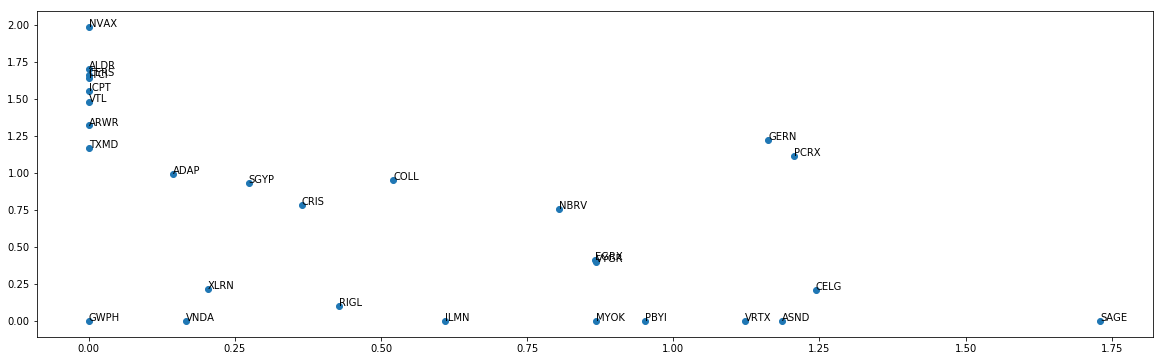

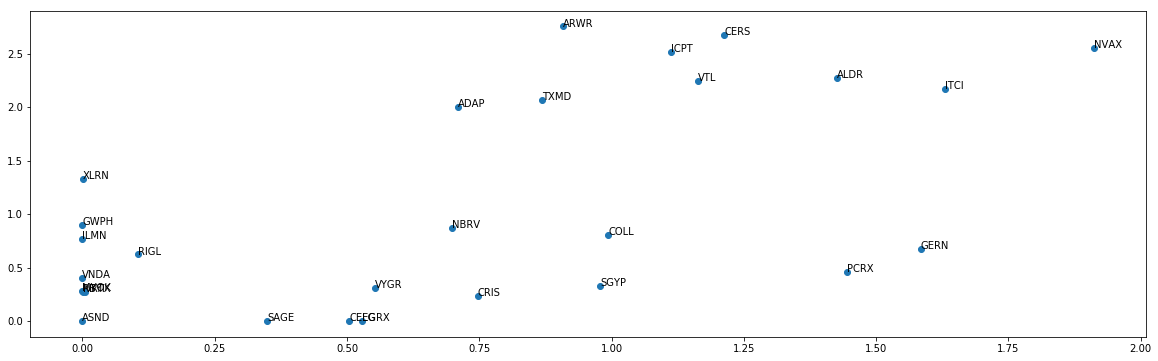

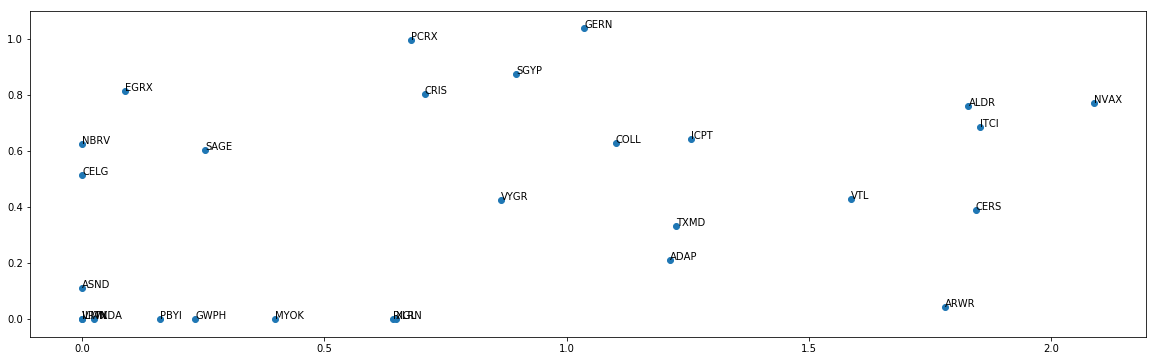

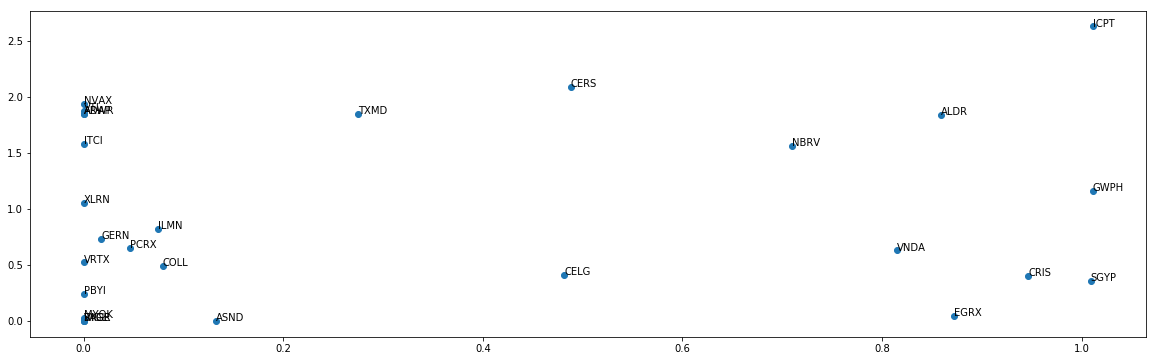

In [75]:
#def train_function(train_setDn, test_setDn):
with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):
        # Placeholders
        x = tf.placeholder("float", [None, num_input])
        phase_train = tf.placeholder(tf.bool)
        keep_prob = tf.placeholder(tf.float32) #gateway for dropout

        # Extract the latent information (logits from the bottleneck layer)
        code, W_e = encoder(x, n_code, phase_train)

        # Extract the outputs of the autoencoder
        output, W_d = decoder(code, n_code, phase_train)

        cost = loss(mse(output,x), regularizer(W_e, W_d), lambd, num_input, batch_size)

        train_op = training(cost, learning_rate)

        eval_op, val_summary_op = evaluate(output, x)

        # Merge all the summaries - variables, training - into a single operation
        summary_op = tf.summary.merge_all()

        # Save the trained model for later use (testing)
        saver = tf.train.Saver()        

        # Create the session list that will be runned for training
        sess_list = [0] * cross_len
        
        total_loss = np.zeros((cross_len,num_steps))
        total_loss_test = np.zeros(cross_len)
        total_p = [0] * cross_len
        total_batchx = [0] * cross_len
        total_testSetDn = [0] * cross_len
        total_tickers_test = [0] * cross_len
        
        start_time = time()
        
        for iteration in range(1,cross_len + 1):
            
            sess_list[iteration-1] = tf.Session()

            # Initialize a summary for our variables during the training
            summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

            # Time to launch the session
            init_op = tf.global_variables_initializer()
            sess_list[iteration - 1].run(init_op)

            steps = [0]*num_steps
            
            next_folder = next_fold(iteration, cross_len)
            
            train_setDn, test_setDn, list_tickers_cross_train, list_tickers_cross_test, train_setD, test_setD = next_folder
                
            total_testSetDn[iteration - 1] = test_setDn
            
            total_tickers_test[iteration - 1] = list_tickers_cross_test
            
            for i in range(1, num_steps + 1):

                # Prepare Data
                total_batch = int(len(train_setData_n) / batch_size)
            

                for j in range(total_batch):
                    mini_batch_x, _ = next_batch(batch_size, train_setDn, train_setDn)

                    _, l, summary = sess_list[iteration-1].run([train_op, cost, summary_op], 
                                feed_dict={x: mini_batch_x, phase_train: True, keep_prob: val_dropout})
                total_loss[iteration-1][i-1] = l
                steps[i-1] = i

                # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
                summary_writer.add_summary(summary, i)

                if i % display_step == 0 or i * iteration == 1:

                    print('Step %i and Iteration %i: Minibatch Loss: %f' % (i, iteration, l))
                    curr_time = time()
                    elapsed_time = curr_time-start_time
                    print('Estimated remaining time = ', (elapsed_time / (num_steps * (iteration - 1) + i) * (num_steps * cross_len - (num_steps * (iteration - 1) + i))),'s\n')

                    # Save the model during the training at save_path
                    #save_path = saver.save(sess, logs_path)
                    #print("Model saved in file: %s" % save_path)

    #                 print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

    #                 train_writer.add_summary(train_summary, sess.run(global_step))

    #                 validation_loss, in_image, out_image, val_summary = sess.run([eval_op, val_summary_op], feed_dict={x: validation_setData, phase_train: False})

    #                 val_writer.add_summary(in_image, sess.run(global_step))
    #                 val_writer.add_summary(out_image, sess.run(global_step))
    #                 val_writer.add_summary(val_summary, sess.run(global_step))

    #                 print("Validation Loss:", validation_loss)

    #                 save_path = saver.save(sess, model_path)
    #                 print("Model saved in file: %s" % save_path)

    #                 curr_time = time()
    #                 elapsed_time = curr_time-start_time
    #                 print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')


    ### Here we plot the latent space (n_code dimension)
            ae_codes, test_loss = sess_list[iteration-1].run([code, cost], 
                                feed_dict={x: test_setData_n, phase_train: False, keep_prob:1})
            fig, ax = plt.subplots()
            ax.scatter(ae_codes[:,0], ae_codes[:,1])
            for i, txt in enumerate(list_tickers_test):
                ax.annotate(txt, (ae_codes[i,0], ae_codes[i,1]))
            
            len_test = len(test_setDn)
            batch_x, _ = next_batch(len_test,test_setDn,test_setDn)
            l , p = sess_list[iteration-1].run([cost, output] , feed_dict={x: batch_x, phase_train: False, keep_prob: 1})
            l = l * batch_size / len_test
            total_loss_test[iteration-1] = l
            total_p[iteration-1] = p
            total_batchx[iteration-1] = batch_x
            print('Minibatch Loss: '+str(l)+'\n\n') 



In [76]:
for i in range(cross_len):
    print('Mean of error of fold %i: %f' % (i+1, total_loss_test[i]))
MSE = np.mean(total_loss_test)
print('\nTotal mean: ',MSE)

Mean of error of fold 1: 0.011968
Mean of error of fold 2: 0.012841
Mean of error of fold 3: 0.013881
Mean of error of fold 4: 0.013028

Total mean:  0.012929522565432956


# 8) Exporting

In [77]:
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/"+date+"/" \
          "\nThen open http://0.0.0.0:6006/ into your web browser\n\n")
print("Or Run the command line:\n" \
          "--> python -m tensorboard.main --logdir=C:\\tmp\\tensorflow_logs\\autoencoder1\\"+date+"\\" \
          "\nThen open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type\n\n")

Run the command line:
--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519688521/
Then open http://0.0.0.0:6006/ into your web browser


Or Run the command line:
--> python -m tensorboard.main --logdir=C:\tmp\tensorflow_logs\autoencoder1\1519688521\
Then open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type




In [78]:
#! tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519250108/

# 9) Plotting

In [79]:
#V2
def denormalize(p,batch, dataset_norm, dataset, list_tickers):
    batch_size = len(batch)
    unnormalized_p = {}
    for j in range(batch_size):
        (ticker, index) = find_ticker_batch(batch[j], dataset_norm, list_tickers)

        minimum = np.min(dataset[index])
        maximum = np.max(dataset[index])
        pred = p[j] * (maximum - minimum) + minimum
        unnormalized_p[index] = (ticker, pred)
        
    return unnormalized_p
    
unnormalized_p = denormalize(p, batch_x, test_setDn, test_setD, list_tickers_cross_test)

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


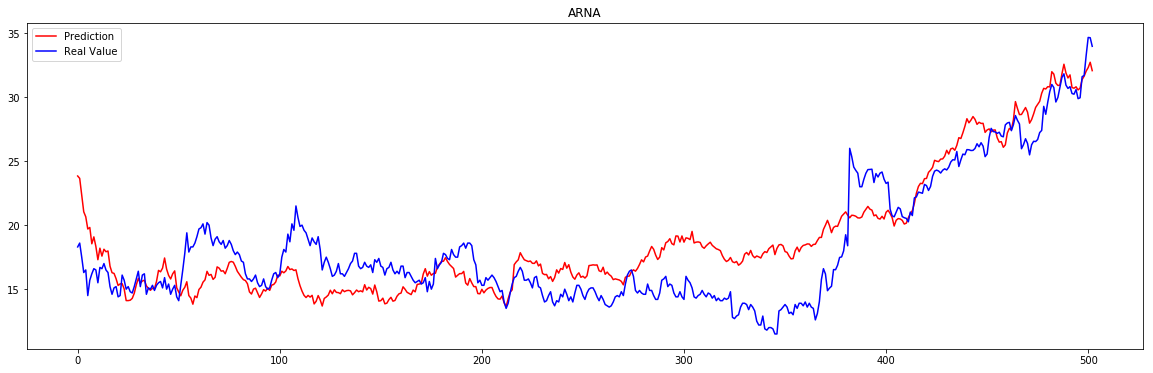

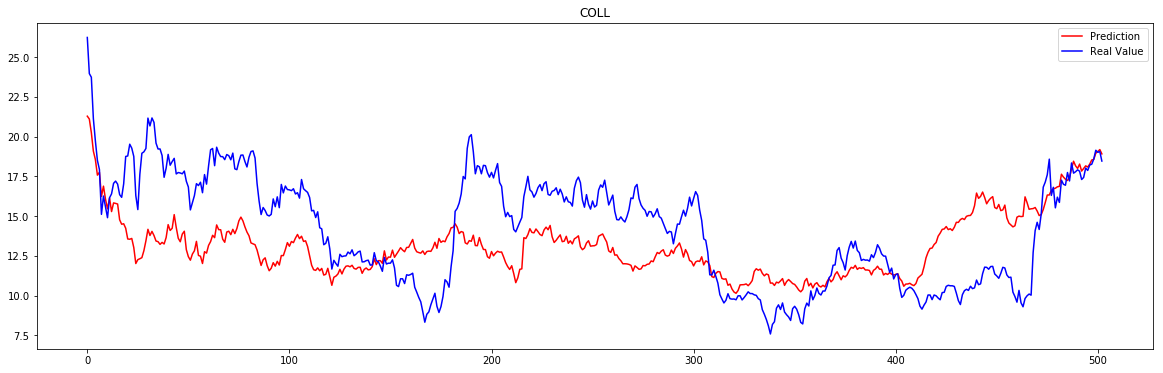

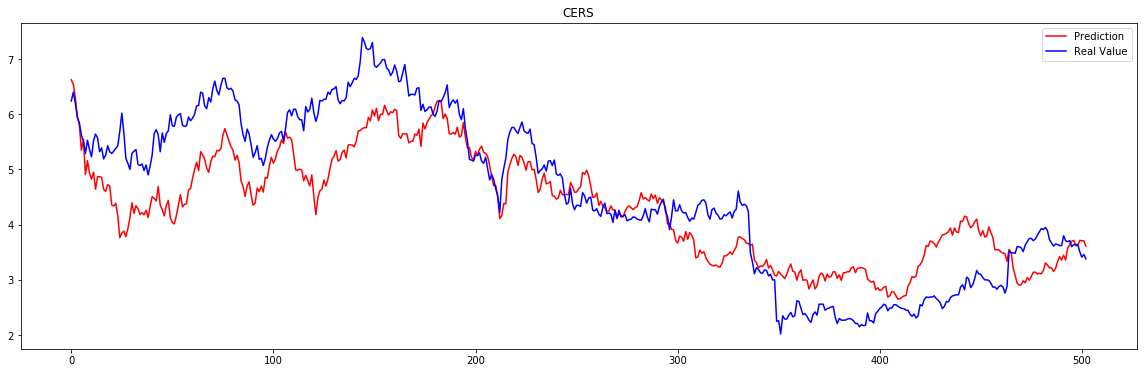

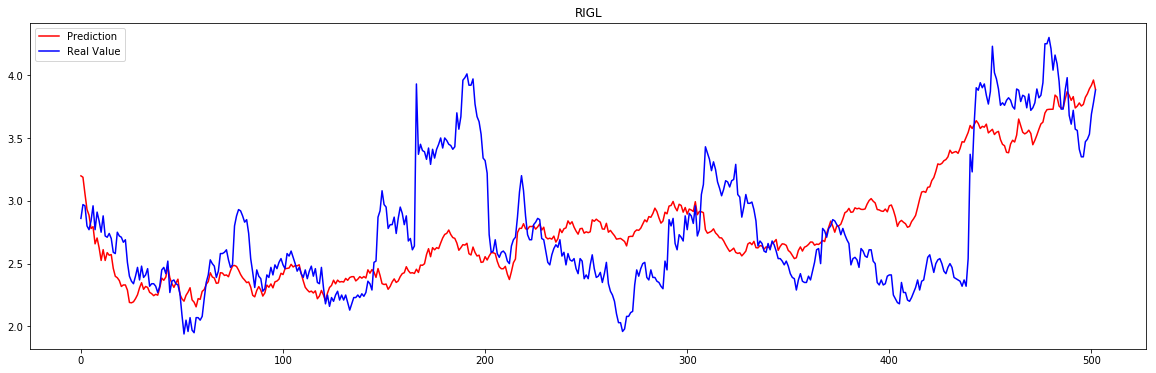

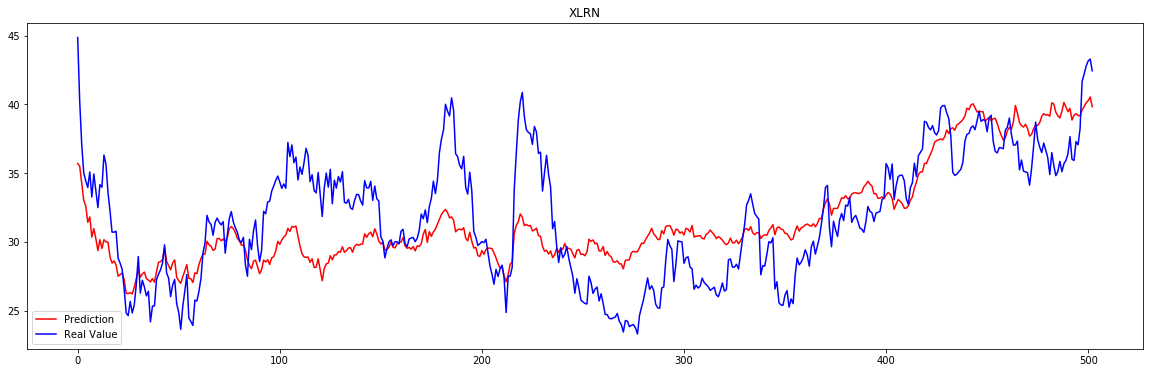

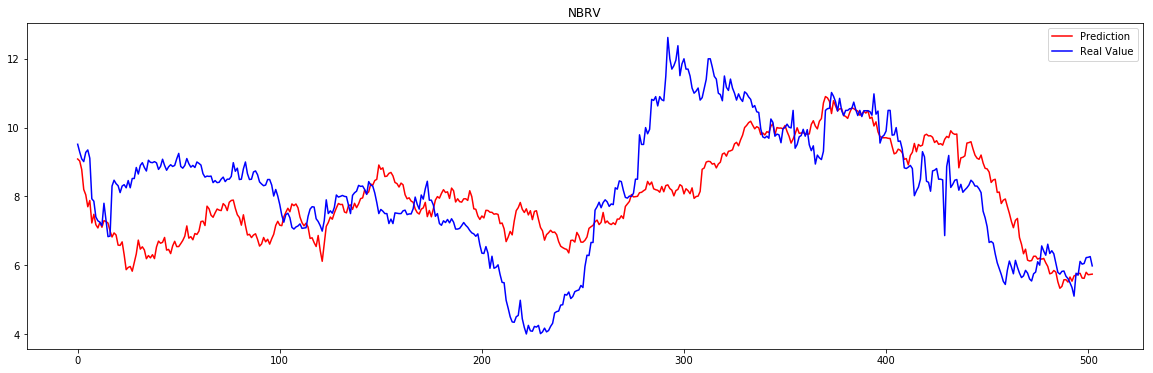

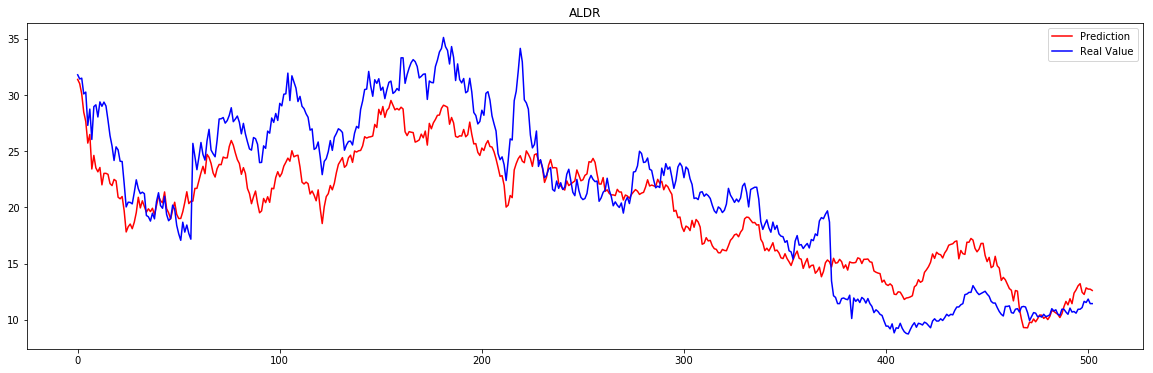

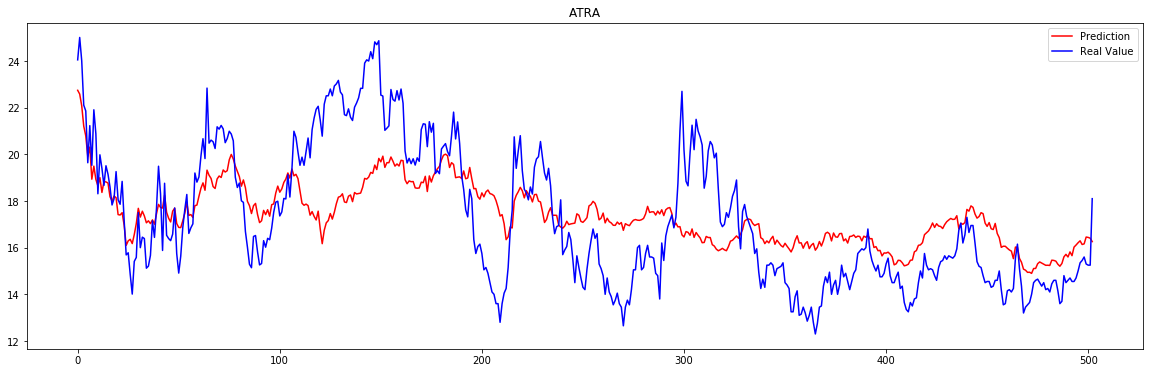

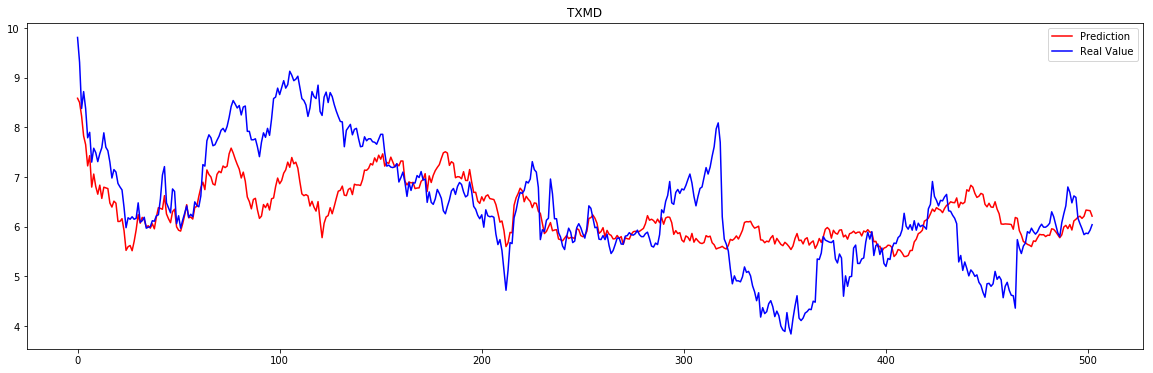

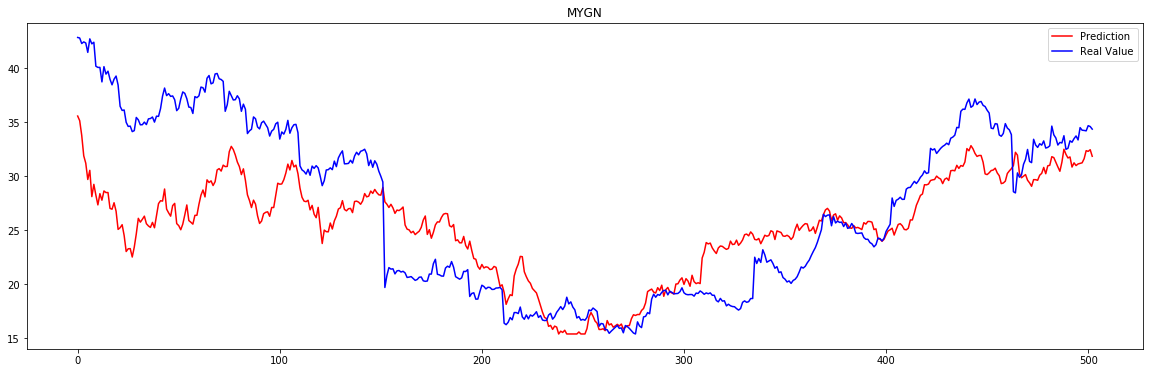

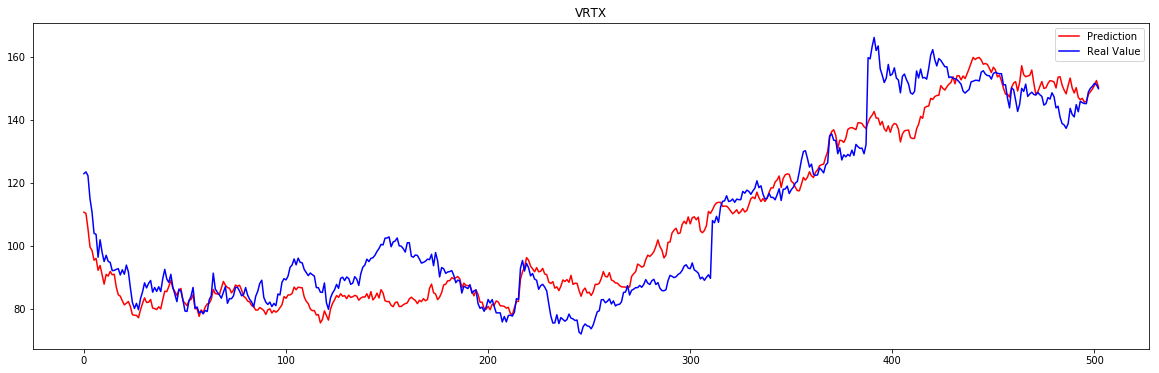

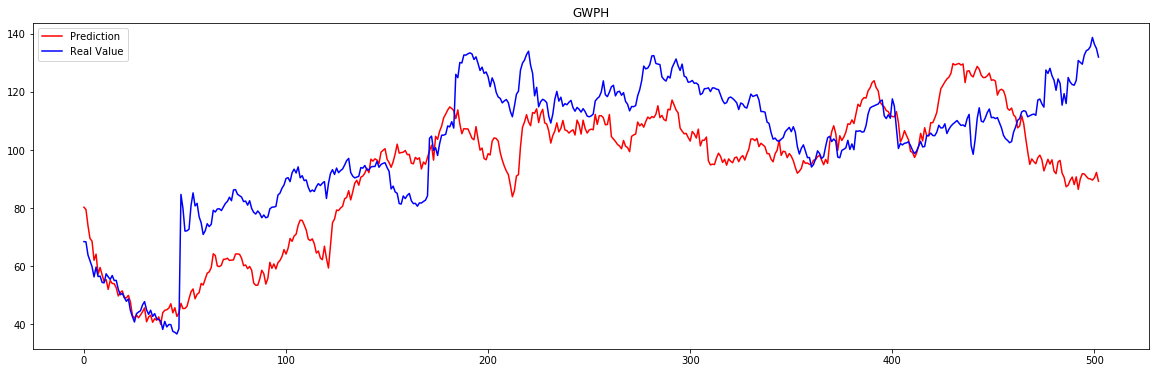

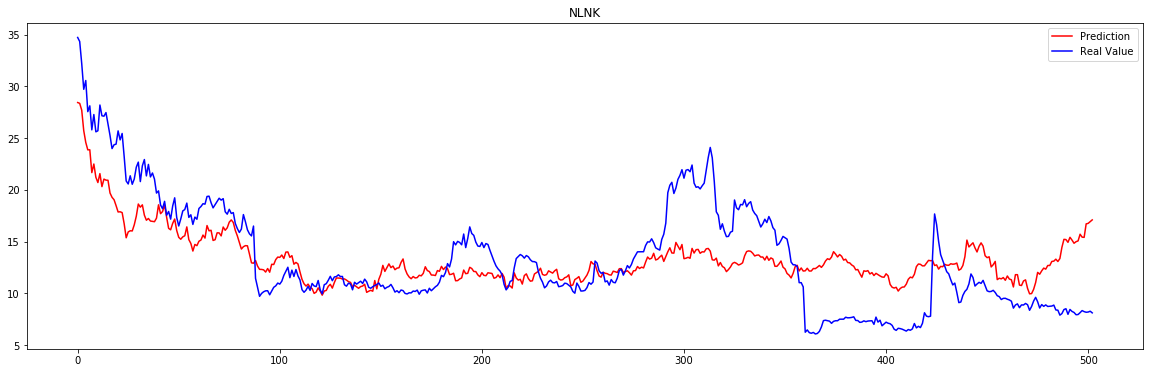

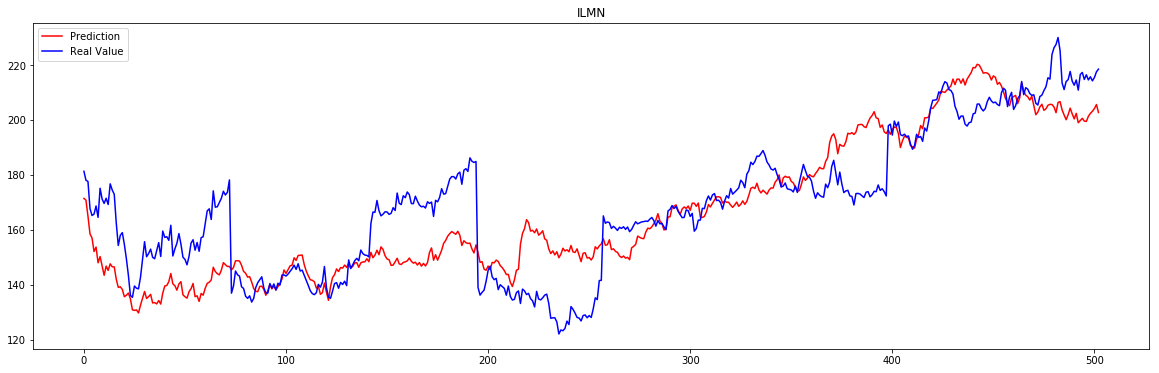

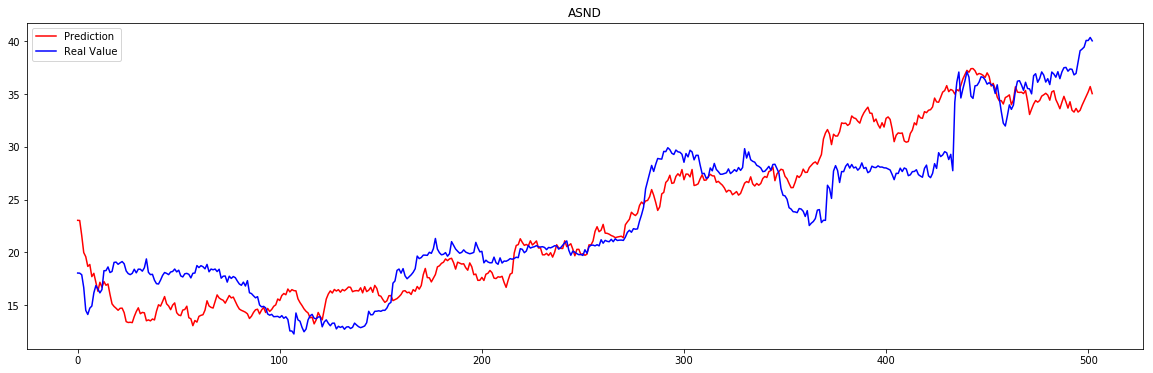

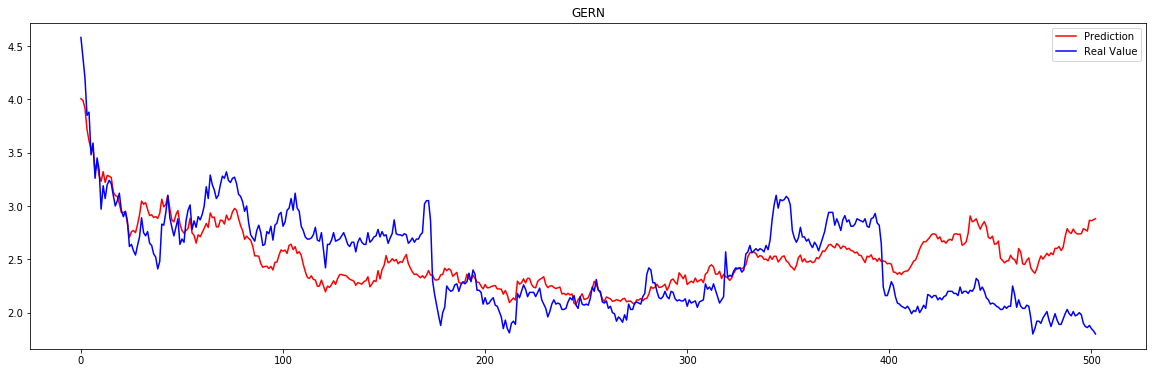

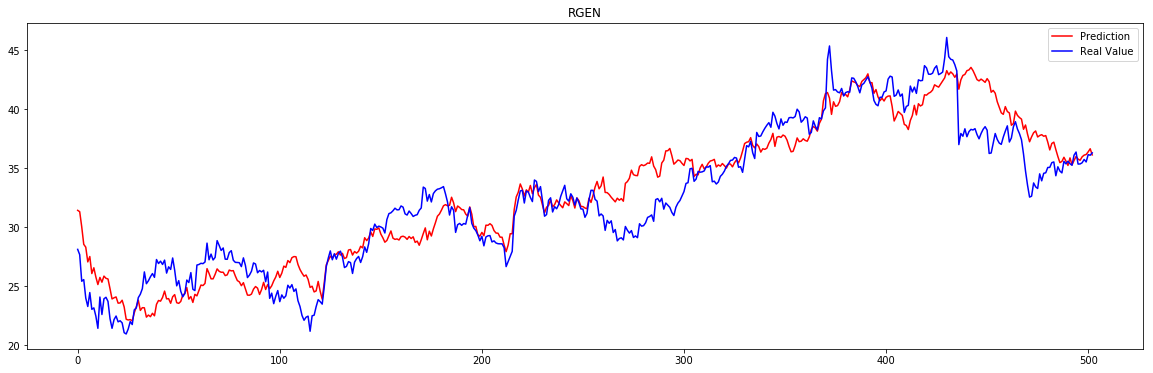

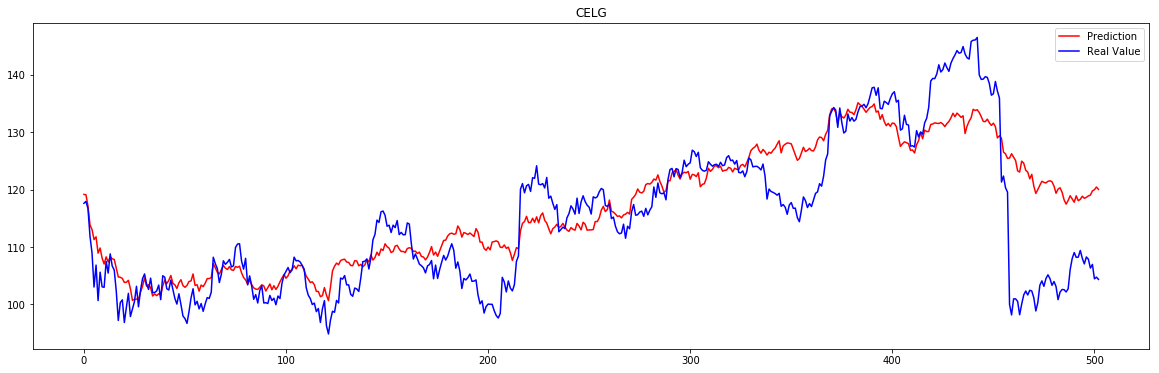

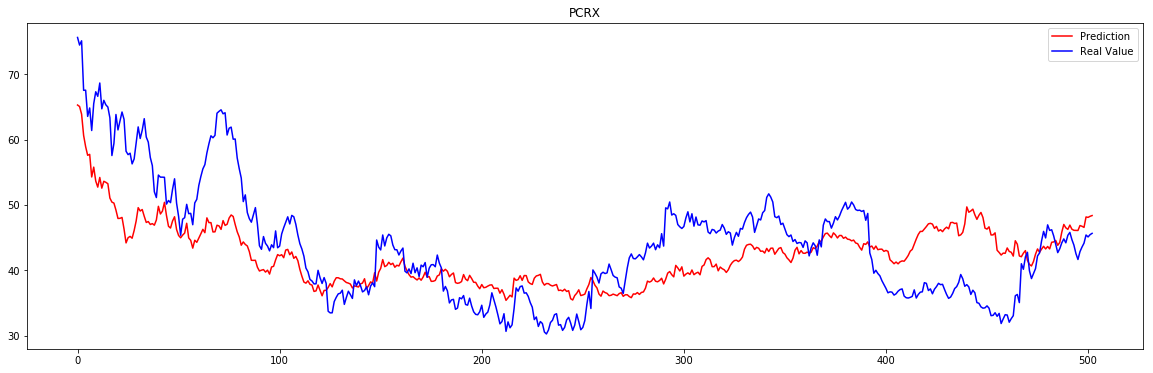

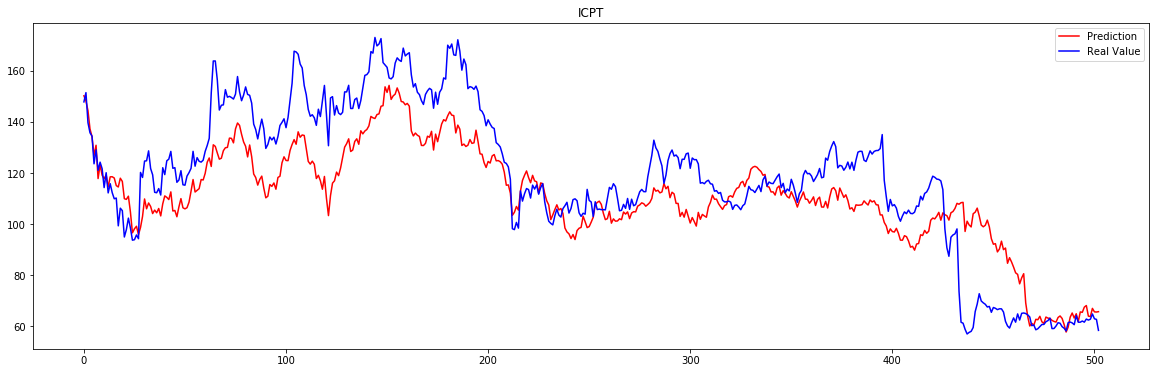

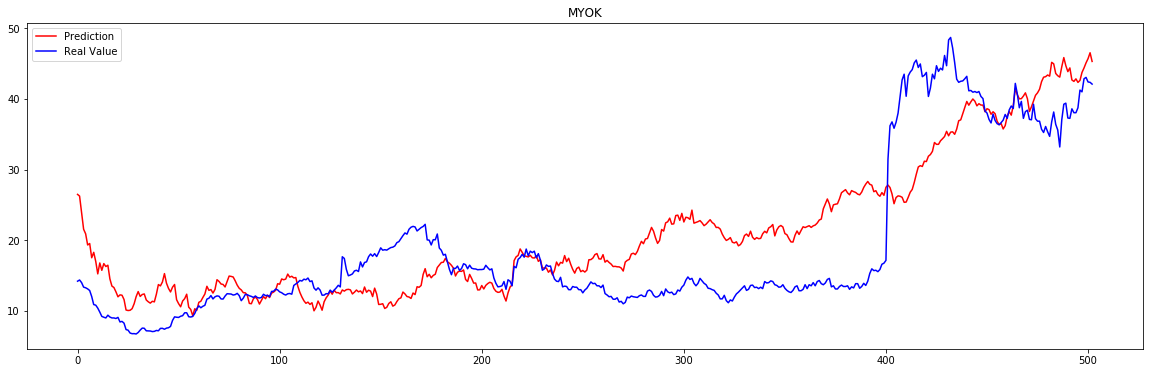

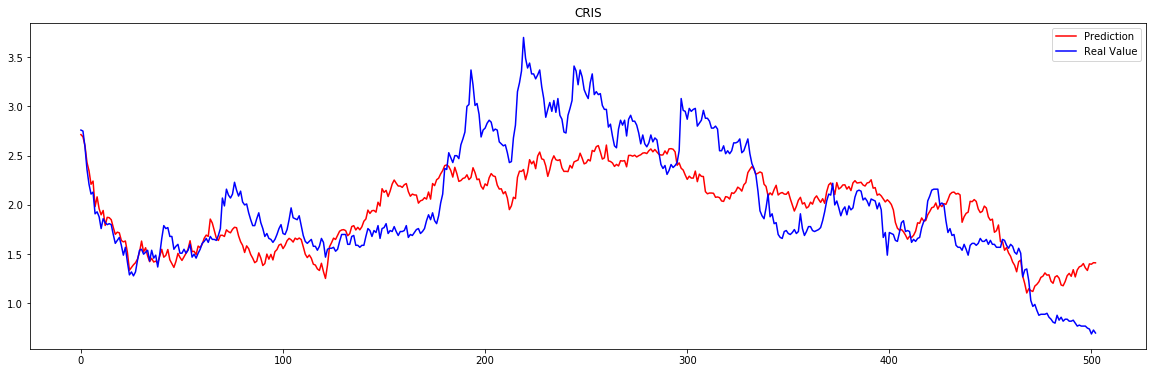

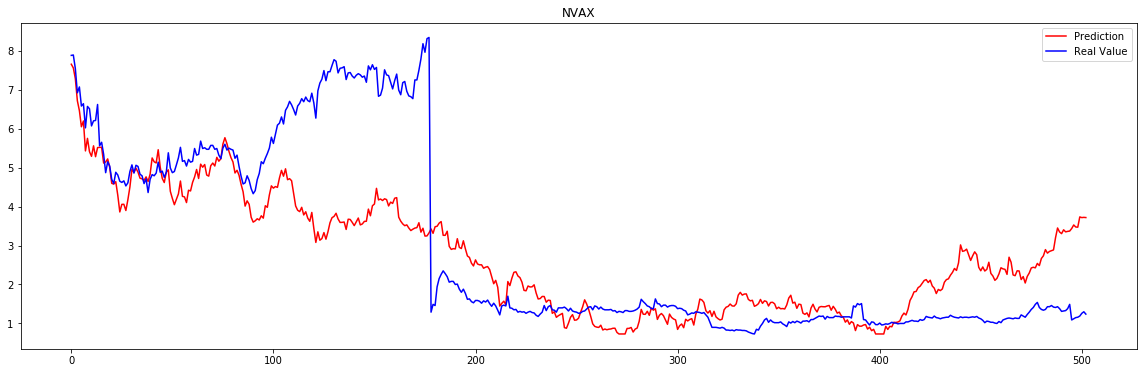

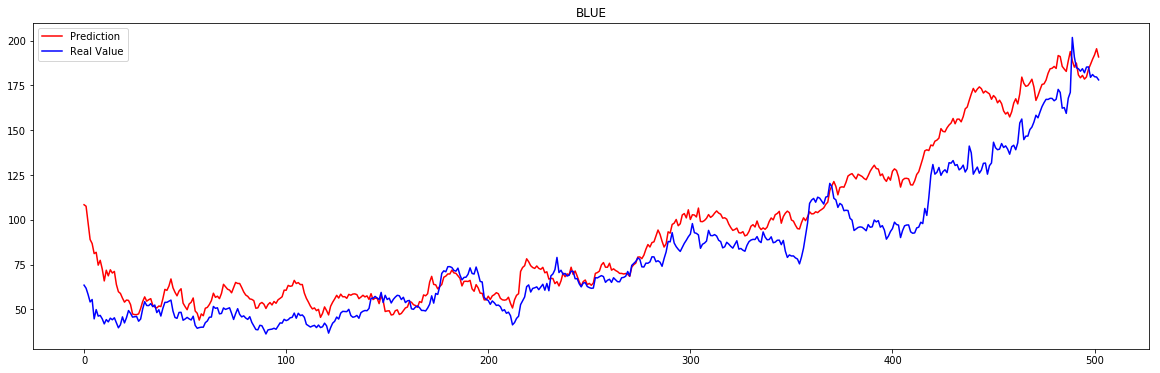

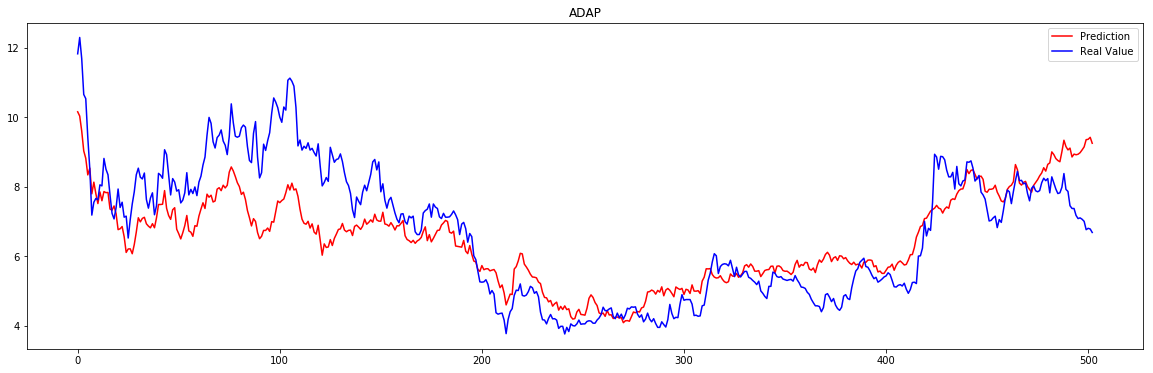

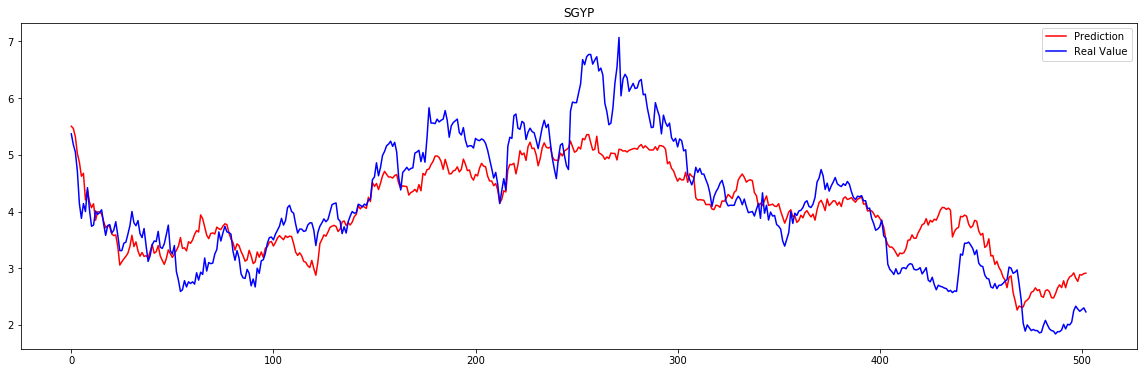

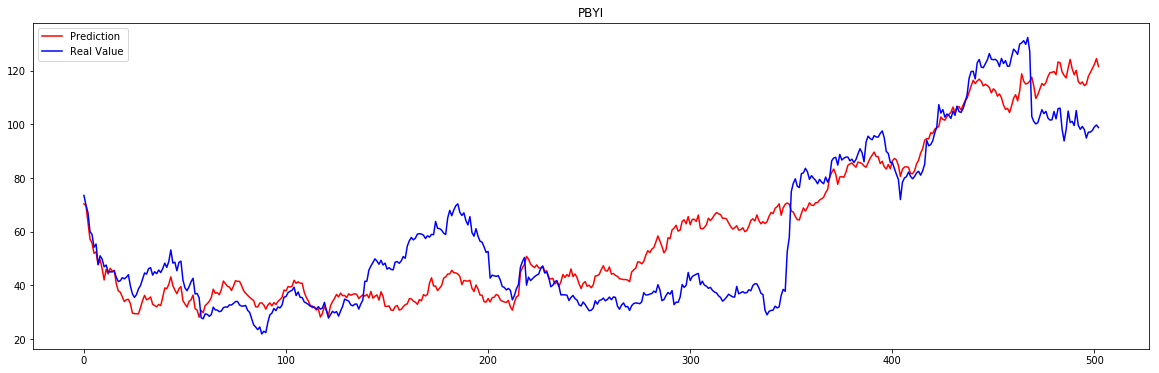

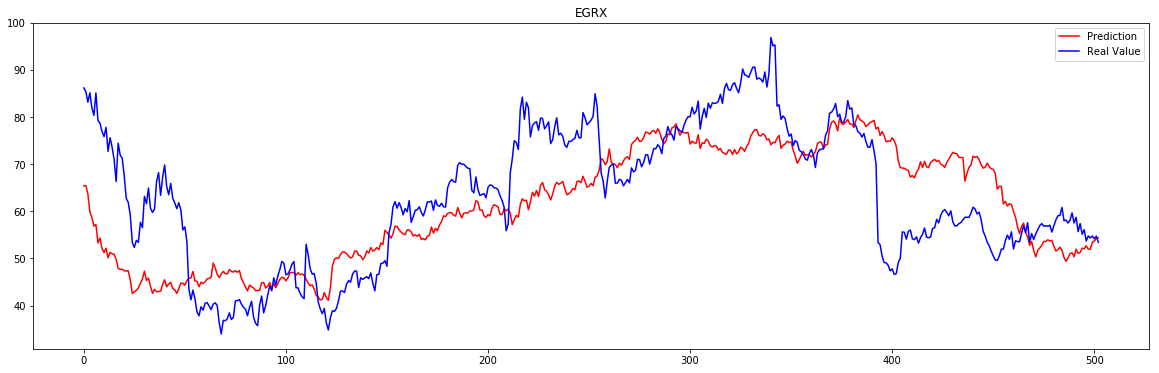

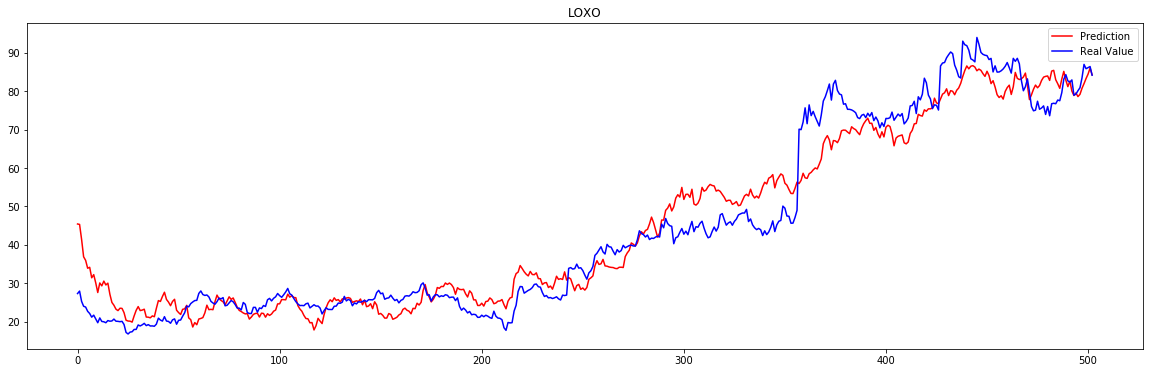

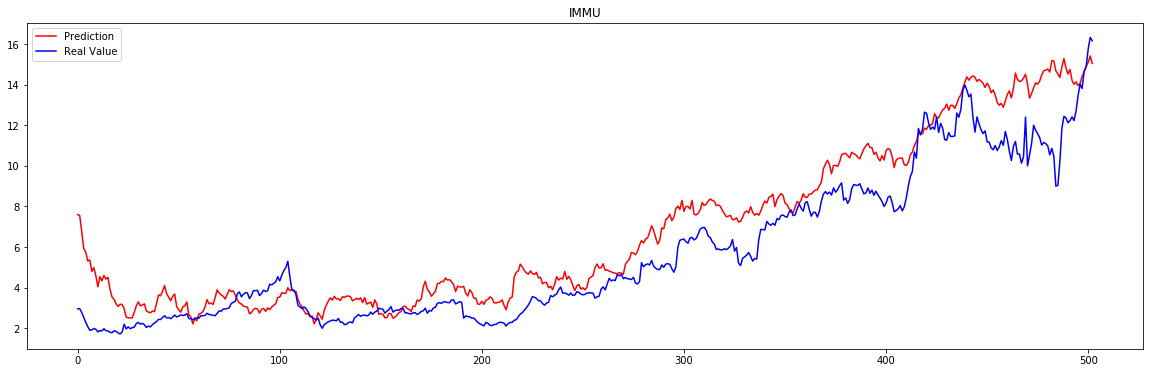

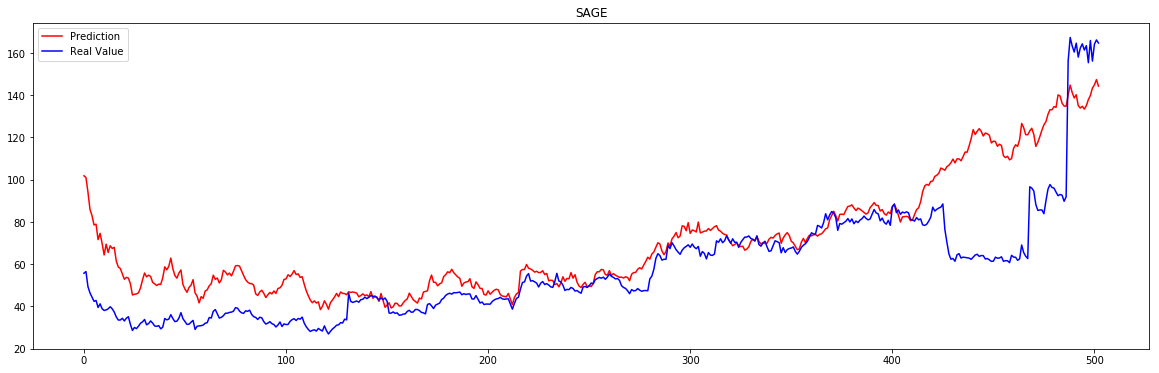

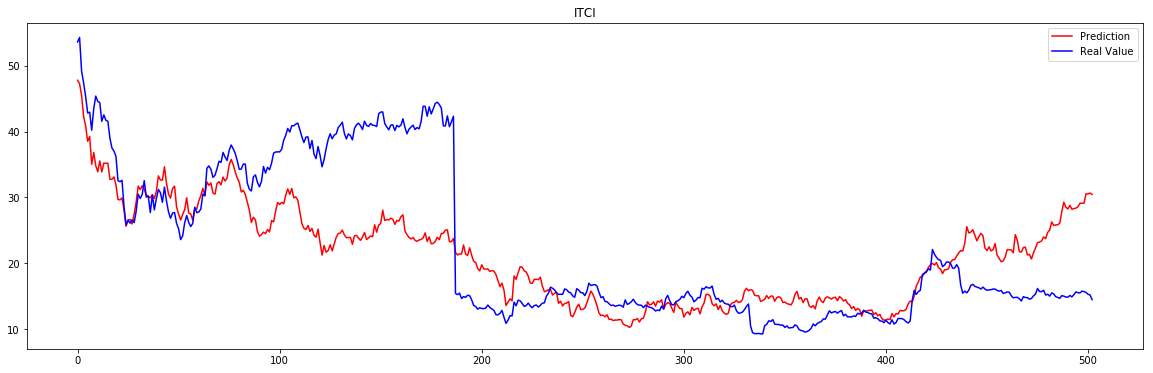

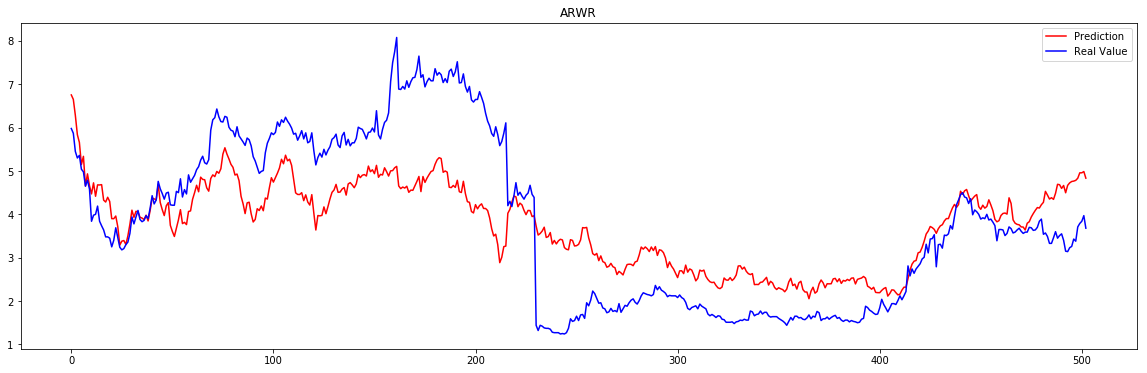

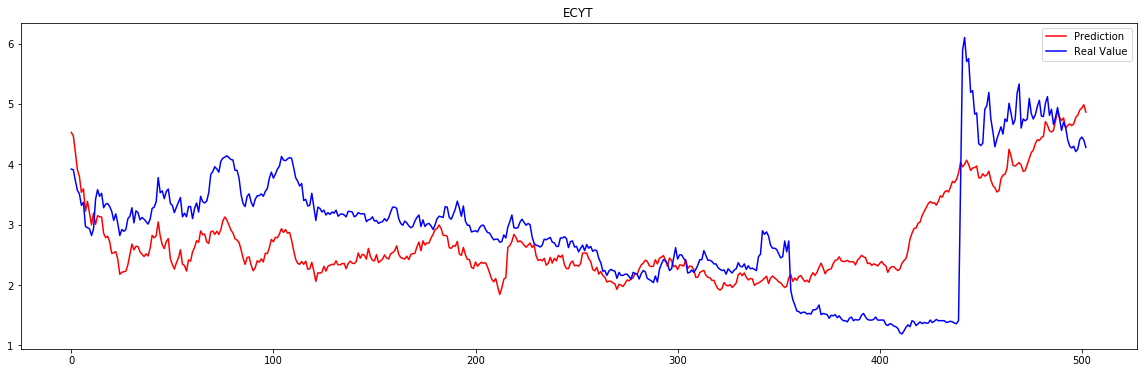

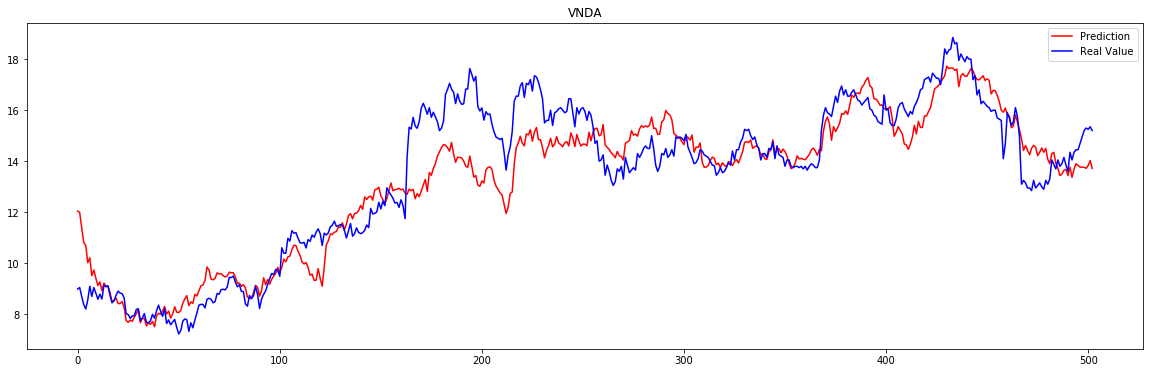

In [80]:
for j in unnormalized_p.keys():
    plt.figure()
    plt.plot(unnormalized_p[j][1] ,'r', label = "Prediction")
    plt.hold
    plt.plot(test_setD[j] ,'b',label = "Real Value")
    plt.title(unnormalized_p[j][0])
    plt.legend()
    plt.show;

# Re checking

In [81]:
diff = abs(p - batch_x)
L2 = np.sqrt(np.multiply(diff,diff))

In [82]:
for i in L2:
    print(i)

[0.23917698 0.21816615 0.20806104 0.20474407 0.17933871 0.22447258
 0.17792861 0.10123477 0.10723056 0.07941096 0.07772453 0.0648498
 0.04239451 0.04824402 0.06146233 0.07260597 0.06881023 0.07275648
 0.04879767 0.02671819 0.03836822 0.03928867 0.02892046 0.02922678
 0.03851051 0.04720734 0.02862888 0.01807988 0.02236716 0.02006535
 0.02417333 0.01179192 0.02014454 0.02155095 0.02854247 0.001832
 0.00371955 0.00994105 0.00543219 0.0131036  0.04173727 0.03260889
 0.06673027 0.06626625 0.06765943 0.02910661 0.05168472 0.05164858
 0.04867039 0.03057597 0.02925908 0.0353248  0.06855297 0.11457013
 0.16496637 0.14680892 0.17266616 0.19315962 0.17849871 0.20561002
 0.20403364 0.20058992 0.19669895 0.15429659 0.16438966 0.169207
 0.12302427 0.11380731 0.12841116 0.10188872 0.08876257 0.09040708
 0.10201121 0.08613146 0.0767753  0.07359779 0.05774324 0.03856194
 0.03975369 0.06502051 0.06663714 0.05480287 0.05850472 0.02281996
 0.01607479 0.04379262 0.0423368  0.03423061 0.0441331  0.03387137


In [83]:
print('average error in our case = ',np.mean(L2))

average error in our case =  0.1120408557068609


In [84]:
random = np.random.uniform(0,1,(len_test,503))

In [85]:
diff_random = abs(batch_x - random)
L2_random = np.sqrt(np.multiply(diff_random,diff_random))
print('average error in a random case = ',np.mean(L2_random))

average error in a random case =  0.33141316421447764


# Finding the commonals

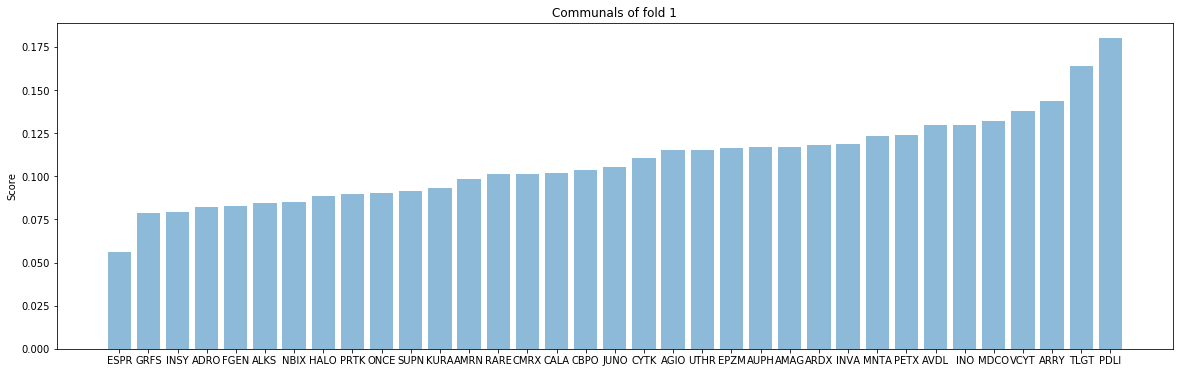

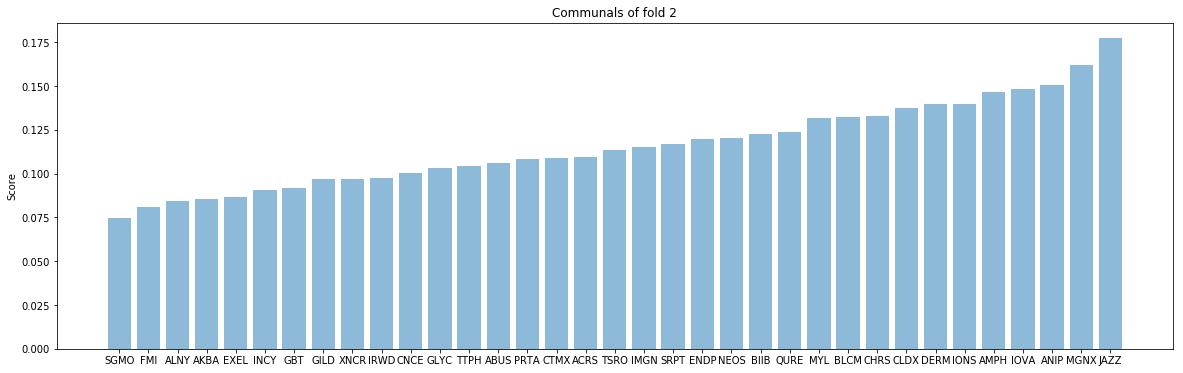

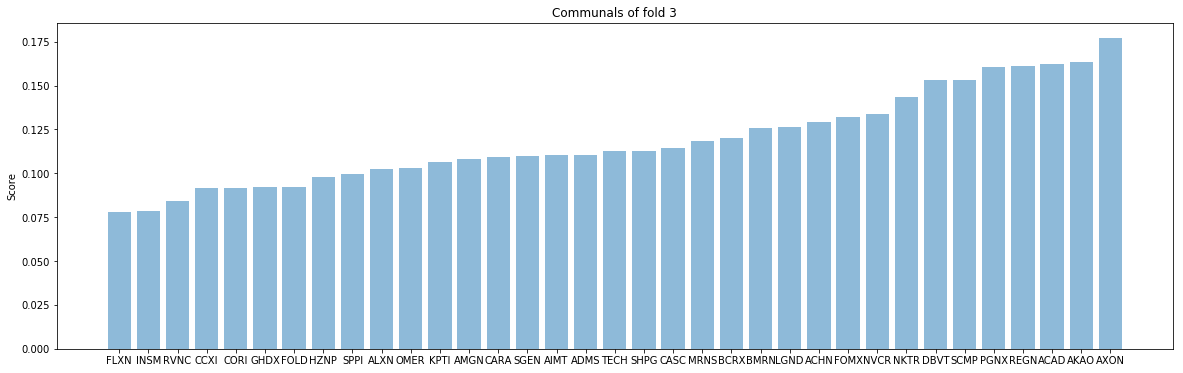

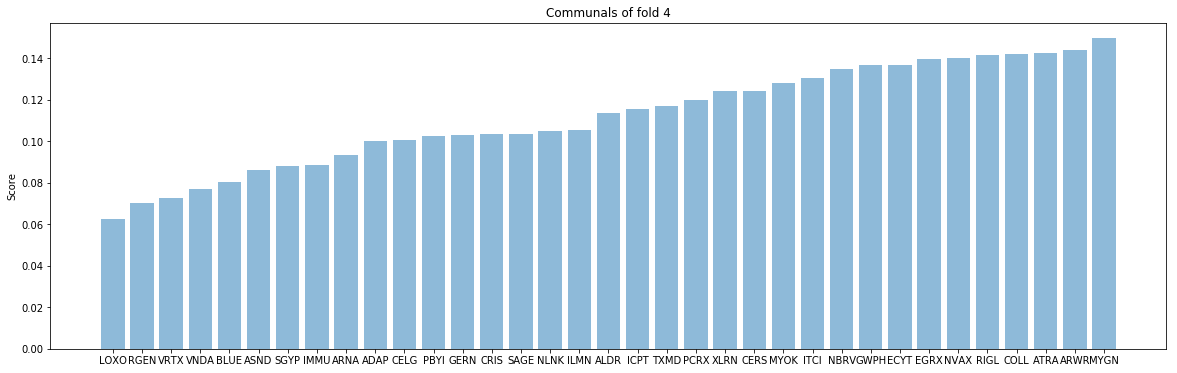

In [86]:
def plot_commonals(p, batch_x, test_setDn, list_tickers_cross_test,fold):
    sorted_by_value = []
    
    diff = abs(p - batch_x)
    L2 = np.sqrt(np.multiply(diff,diff))
    
    for i in range(len(p)):
        sorted_by_value.append((np.mean(L2[i]),i))

    objects =  []
    performance = sorted(sorted_by_value)

    for i in performance:
        ticker, index = find_ticker_batch(batch_x[i[1]], test_setDn, list_tickers_cross_test)
        objects.append(ticker)


    y_pos = np.arange(len(objects))
    plotable_performance = [i[0] for i in performance]

    
    plt.figure()
    plt.bar(y_pos, plotable_performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Score')
    plt.title('Communals of fold '+str(fold + 1))

    plt.show();


all_test_p = []
all_test_batch = []
all_test_test_setDn = []
all_test_list_tickers = []

for fold in range(cross_len):
    p = total_p[fold]
    batch_x = total_batchx[fold]
    test_setDn = total_testSetDn[fold]
    list_tickers_cross_test = total_tickers_test[fold]
    plot_commonals(p, batch_x, test_setDn, list_tickers_cross_test,fold)
    
    all_test_p += list(p)
    all_test_batch += list(batch_x)
    all_test_test_setDn += list(test_setDn)
    all_test_list_tickers += list(list_tickers_cross_test)



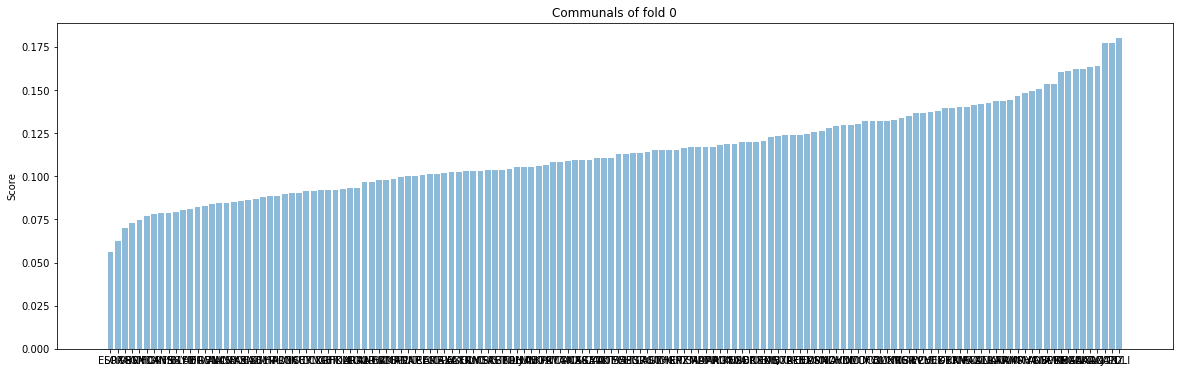

In [87]:
p = np.array(all_test_p)
batch_x = np.array(all_test_batch)
test_setDn = all_test_test_setDn
list_tickers_cross_test = all_test_list_tickers

plot_commonals(p, batch_x, test_setDn, list_tickers_cross_test,-1)

In [88]:
fields = ['learning_rate', 'num_steps', 'batch_size', 'lambd', 'val_dropout', 'cross_len', 'num_encode_1', 'n_code', 'MSE']
values = [learning_rate, num_steps, batch_size, lambd, val_dropout, cross_len, num_encode_1, n_code, MSE]

In [89]:
ROOTPATH = os.getcwd()

if not os.path.isfile('results.csv'):
    if computer == 0:
        with open('results.csv', 'a') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
            spamwriter.writerow(fields)
    else:
        with open('results.csv', 'a', encoding ='mac_roman') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
            spamwriter.writerow(fields)


if computer == 0:
    with open('results.csv', 'a') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(values)
else:
    with open('results.csv', 'a', encoding ='mac_roman') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(values)
        
